In [414]:
# Classical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

# Misc
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 7

This notebook is inspired by Sebastian Ruder's awesome work... from http://ruder.io/optimizing-gradient-descent/

### References

* http://www.fast.ai/, Fast.ai ML, Fast.ai DL
* http://ruder.io/optimizing-gradient-descent/
* http://cs231n.github.io/neural-networks-3/#sgd

In [280]:
data = pd.read_csv('./data/MNIST/train.csv')
data = np.array(data)

In [313]:
class MNIST(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __getitem__(self, index):
        X = data[index][1:]
        y = data[index][0]
        return torch.from_numpy(X).float(), torch.LongTensor(np.array([y]))
    
    def __len__(self):
        return len(self.data)

In [338]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        for i in range(len(self.linears) - 1):
            lin = self.linears[i]
            x = F.relu(lin(x))
        lin_out = self.linears[-1]
        out = lin_out(x)
        return torch.log(F.softmax(out))

In [520]:
# Create dataset
mnist = MNIST(data)
data_dl = DataLoader(mnist, batch_size= 256, shuffle=True, num_workers=0)

### Training With DIfferent Optimizers

In [521]:
epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function 

### Vanilla Mini Batch -  SGD

In [ ]:
### Algorithm
for i in range(epochs):
    shuffled = np.random.shuffle(data)
    for batch in get.batch(shuffled, bs):
        grads = compute.grads(batch,weight, loss_func)
        params -= lr*grads

In [453]:
### init architecture
snet = SimpleNet([784, 100, 100, 10])

### get weight, bias objects
wbs = [(lin.weight, lin.bias) for lin in snet.linears]

### keep track of training loss
losses = []

###params
lr = 1e-3

### Training 
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        # compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # update weights 
        for w, b in wbs:
            w.data -= lr*w.grad.data
            b.data -= lr*b.grad.data
            # zero the gradients
            w.grad.data.zero_()
            b.grad.data.zero_()
        

epoch 0
epoch 1
epoch 2


In [454]:
sgd_losses_ = [(l.data.numpy()[0]) for l in losses]
sgd_log_losses_ = [np.log(l) for l in losses_]

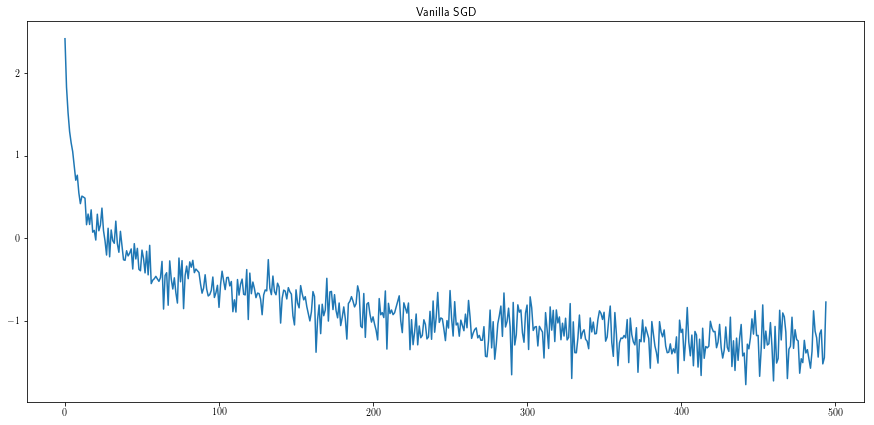

In [455]:
plt.plot(sgd_log_losses_)
title = plt.title("Vanilla SGD")

### SGD with momentum

We'd like to pass saddle points with the use of momentum, if not it's faster...

In [ ]:
### Algorihtm
v_new = 0 #init update
rho = 0.9 #set rho
for i in range(epochs):
    shuffled = np.random.shuffle(data)
    for batch in get.batch(shuffled, bs):
        v_new = rho*v_prev + lr*compute.grads(batch, weight, loss_func)
        params -= v_new
        v_prev = v_new 

In [502]:
### init architecture
snet = SimpleNet([784, 100, 100, 10])

### get weight, bias objects
wbs = [(lin.weight, lin.bias) for lin in snet.linears]

### keep track of training loss
losses = []

###params
lr = 1e-3
rho = 0.9
weight_v_prev = [0 for i in range(len(wbs))] # initialize momentum term
bias_v_prev = [0 for i in range(len(wbs))] # initialize momentum term

epochs = 3

### Training 
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        # compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # update weights 
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            weight_v_new = rho*weight_v_prev[i] + lr*w.grad.data
            bias_v_new = rho*bias_v_prev[i] + lr*b.grad.data
            
            weight_v_prev[i] = weight_v_new
            bias_v_prev[i] = bias_v_new
            
            w.data -= weight_v_new
            b.data -= bias_v_new
            
            # zero the gradients
            w.grad.data.zero_()
            b.grad.data.zero_()
        

epoch 0
epoch 1
epoch 2


In [503]:
sgdmom_losses_ = [(l.data.numpy()[0]) for l in losses]
sgdmom_log_losses_ = [np.log(l) for l in sgdmom_losses_]

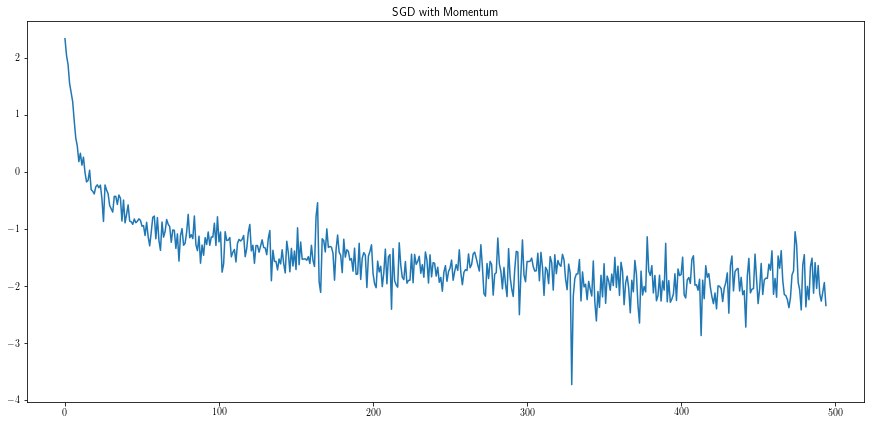

In [504]:
plt.plot(sgdmom_log_losses_)
title = plt.title("SGD with Momentum")

### Nesterov 

We'd like to have a smarter ball, a ball that has a notion of where it is going so that it knows to slow down before the hill slopes up again. While computing grads wrt to weight - rho*v_prev, we have a sense of what will be the next position of our ball will, so we can leverage this and make a better update.

In [ ]:
###Algorithm
v_prev = 0 #init update
rho = 0.9 #set rho
for i in range(epochs):
    shuffled = np.random.shuffle(data)
    for batch in get.batch(shuffled, bs):
        v_new = rho*v_prev + lr*compute.grads(batch, params - rho*v_prev, loss_func)
        params -= v_new
        v_prev = v_new

In [572]:
### init architecture
snet = SimpleNet([784, 100, 100, 10])

### get weight, bias objects
wbs = [(lin.weight, lin.bias) for lin in snet.linears]

### keep track of training loss
losses = []

###params
lr = 1e-3
rho = 0.9
weight_v_prev = [0 for i in range(len(wbs))] # initialize momentum term
bias_v_prev = [0 for i in range(len(wbs))] # initialize momentum term

epochs = 3

### Training 
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for n, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        # compute loss
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        
        # update weights 
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            
            ### WEIGHT UPDATE
            # take a step in future as if we are updating
            w_original = w.data
            w.data -= rho*weight_v_prev[i]
            # caluclate loss and gradients, to see how would it be 
            future_outputs = snet(inputs)
            future_loss = criterion(outputs, labels.squeeze(-1))
            future_loss.backward(retain_graph=True)
            future_grad = w.grad.data
                     
            weight_v_new = rho*weight_v_prev[i] + lr*future_grad #future grad
            weight_v_prev[i] = weight_v_new
            w.data = w_original #get the original weight data
            w.data -= weight_v_new #update
            
            # zero all gradients
            for i_sub, wb_sub in enumerate(wbs):
                w_sub = wb_sub[0]
                b_sub = wb_sub[1]
                w_sub.grad.data.zero_()
                b_sub.grad.data.zero_()
            
            
            ### BIAS UPDATE
            # take a step in future as if we are updating
            b_original = b.data
            b.data -= rho*bias_v_prev[i]
            
            # calculate loss and gradient, to see how would it be
            future_outputs = snet(inputs)
            future_loss = criterion(outputs, labels.squeeze(-1))
            future_loss.backward(retain_graph=True)
            future_grad = b.grad.data
            
            bias_v_new = rho*bias_v_prev[i] + lr*future_grad
            bias_v_prev[i] = bias_v_new
            b.data = b_original
            b.data -= bias_v_new
            
            # zero all gradients
            for i_sub, wb_sub in enumerate(wbs):
                w_sub = wb_sub[0]
                b_sub = wb_sub[1]
                w_sub.grad.data.zero_()
                b_sub.grad.data.zero_()            

epoch 0
epoch 1
epoch 2


In [573]:
nesterov_losses_ = [(l.data.numpy()[0]) for l in losses]
nesterov_log_losses_ = [np.log(l) for l in nesterov_losses_]

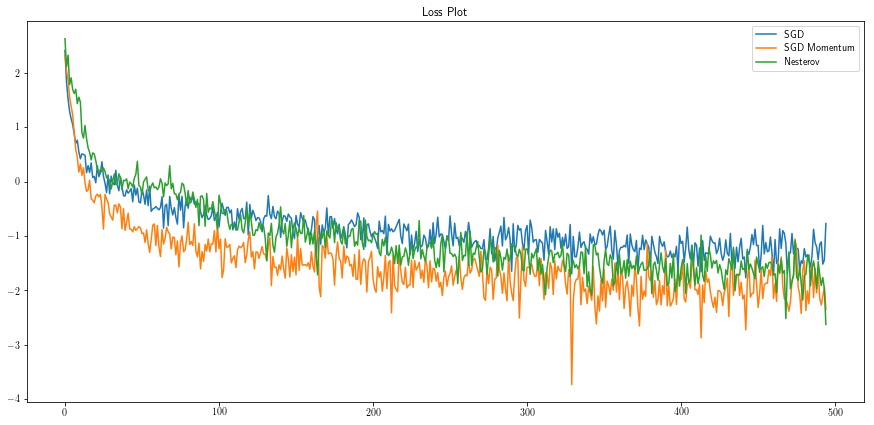

In [575]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
title = plt.title("Loss Plot")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov'))